In [1]:
import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io
from shapely.geometry import Polygon

import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

from dataset_preparing import get_coords_from_densifing_points, generate_heatmap
# dense에 대한 간격이나 표준편차를 하이퍼 파라미터로 조정가능한 코드. 히트맵 생성 때문에 속도는 좀 걸릴 수 있음
# Inria 데이터 크기 조정하여 coco 포맷으로 맞춰준 데이터 처리가능

def min_max_normalize(image, percentile, nodata=-1.):
    image = image.astype('float32')
    mask = np.mean(image, axis=2) != nodata * image.shape[2]

    percent_min = np.percentile(image, percentile, axis=(0, 1))
    percent_max = np.percentile(image, 100-percentile, axis=(0, 1))

    if image.shape[1] * image.shape[0] - np.sum(mask) > 0:
        mdata = np.ma.masked_equal(image, nodata, copy=False)
        mdata = np.ma.filled(mdata, np.nan)
        percent_min = np.nanpercentile(mdata, percentile, axis=(0, 1))

    norm = (image-percent_min) / (percent_max - percent_min)
    norm[norm < 0] = 0
    norm[norm > 1] = 1
    norm = (norm * 255).astype('uint8') * mask[:, :, np.newaxis]

    return norm


def image_graph_collate_road_network_coco(batch):
    images = torch.stack([item['image'] for item in batch], 0).contiguous()
    heatmap = torch.stack([item['heatmap'] for item in batch], 0).contiguous()
    points = [item['nodes'] for item in batch]
    edges = [item['edges'] for item in batch]

    return [images, heatmap, points, edges]


def create_polygon(segmentation):
    # COCO segmentation format is [x1, y1, x2, y2, ..., xn, yn]
    # We need to reshape it to [(x1, y1), (x2, y2), ..., (xn, yn)]
    points = list(zip(segmentation[::2], segmentation[1::2]))
    return Polygon(points)


def gdf_to_nodes_and_edges(gdf):
    nodes = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            for x, y in polygon.exterior.coords:
                nodes.append((x, y))
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                for x, y in part.exterior.coords:
                    nodes.append((x, y))
        else:
            raise AttributeError

    # Remove duplicates if necessary
    nodes = list(set(nodes))

    # Create a DataFrame for nodes with unique indices
    node_df = pd.DataFrame(nodes, columns=['x', 'y'])
    node_df['node_id'] = range(len(node_df))

    edges = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            coords = polygon.exterior.coords[:-1]  # Exclude closing vertex
            edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                    node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                    for i, (x, y) in enumerate(coords)]
            edges.extend(edge)
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                coords = part.exterior.coords[:-1]
                edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                        node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                        for i, (x, y) in enumerate(coords)]
                edges.extend(edge)

    return node_df[['y', 'x']].values, edges


class CrowdAI(Dataset):
    """A dataset class for handling and processing data from the CrowdAI dataset.

    Attributes:
        IMAGES_DIRECTORY (str): Directory containing the images.
        ANNOTATIONS_PATH (str): File path for the annotations.
        coco (COCO): COCO object to handle COCO annotations.
        max_points (int): Maximum number of points to consider (default 256).
        gap_distance (float): Distance between interpolated points.
        sigma (float): Standard deviation for Gaussian kernel used in heatmap generation.

    Args:
        images_directory (str): Directory where the dataset images are stored.
        annotations_path (str): File path for the COCO format annotations.
        gap_distance (int, optional): Gap distance for densifying points. Defaults to 20.
        sigma (float, optional): Sigma value for Gaussian blur in heatmap. Defaults to 1.5.
    """

    def __init__(self, 
                 images_directory, 
                 annotations_path,
                 gap_datance=20,
                 sigma=1.5):

        self.IMAGES_DIRECTORY = images_directory
        self.ANNOTATIONS_PATH = annotations_path
        self.coco = COCO(self.ANNOTATIONS_PATH)
        self.image_ids = self.coco.getImgIds(catIds=self.coco.getCatIds())

        self.len = len(self.image_ids)

        self.max_points = 256 # TODO: It should be restricted the number when gt points over the max points limit
        self.gap_distance = gap_datance
        self.sigma = sigma

    def prepare_annotations(self, img):
        """Prepares annotations for an image.
        Args:
            img (dict): A dictionary containing image metadata.

        Returns:
            GeoDataFrame: A GeoDataFrame containing the geometrical data of annotations.
        """
        annotation_ids = self.coco.getAnnIds(imgIds=img['id'])
        annotations = self.coco.loadAnns(annotation_ids)
        random.shuffle(annotations)

        data = []
        for ann in annotations:
            polygon = create_polygon(ann['segmentation'][0])
            data.append({'id': ann['id'], 'geometry': polygon})
        gdf = gpd.GeoDataFrame(data, geometry='geometry')
        return gdf

    def loadSample(self, idx):
        """Loads a sample for a given index.

        Args:
            idx (int): The index of the sample to load.

        Returns:
            dict: A dictionary containing the sample data.
                'image' (torch.Tensor of shape [3, H, W], torch.float32): 
                    The image tensor normalized to [0, 1].
                'image_idx' (torch.Tensor of shape [1], torch.long): 
                    The index of the image.
                'heatmap' (torch.Tensor of shape [H, W], torch.float32): 
                    The heatmap tensor for the image normalized to [0, 1]. 
                'nodes' (torch.Tensor of shape [N, 2], torch.float): 
                    The nodes tensor representing points in the image.
                    nodes are normalized to [0, 1]
                'edges' (torch.Tensor of shape [E, 2], torch.long): 
                    The edges tensor representing connections between nodes.
        """
        idx = self.image_ids[idx]

        img = self.coco.loadImgs(idx)[0]
        image_path = os.path.join(self.IMAGES_DIRECTORY, img['file_name'])
        image = io.imread(image_path)

        gdf = self.prepare_annotations(img)
        coords, gdf = get_coords_from_densifing_points(gdf, gap_distance=self.gap_distance) # [N, 2]
        heatmap = generate_heatmap(coords, image.shape[:2], sigma=self.sigma)

        nodes, edges = gdf_to_nodes_and_edges(gdf)
        nodes = nodes / image.shape[0]

        image_idx = torch.tensor([idx])
        image = torch.from_numpy(image)
        image = image.permute(2,0,1) / 255.0
        heatmap = torch.from_numpy(heatmap) / 255.0
        
        nodes = torch.tensor(nodes, dtype=torch.float)
        edges = torch.tensor(edges, dtype=torch.long)

        sample = {
            'image': image, 
            'image_idx': image_idx, 
            'heatmap': heatmap,
            'nodes': nodes,
            'edges': edges
            }
        return sample

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = self.loadSample(idx)
        return sample

In [2]:
from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

### Inria cocostyle GT 예시

loading annotations into memory...
Done (t=2.34s)
creating index...
index created!
torch.Size([6, 3, 300, 300])


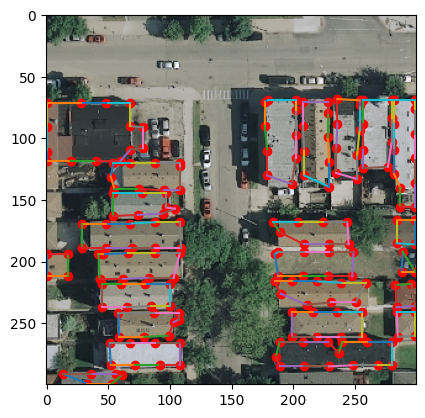

In [3]:
dataset = CrowdAI(images_directory='/nas/tsgil/dataset/Inria_building/cocostyle/images',
                    annotations_path='/nas/tsgil/dataset/Inria_building/cocostyle/annotation.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# 6개의 이미지 중 1번째 GT
image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][1].detach().cpu().numpy()
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

nodes = nodes.astype('int64')

# Visualize
plt.imshow(min_max_normalize(image, 0))
plt.scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
plt.show()

TopDiG, 백본 ckpt 불러오기

In [4]:
config_file = "configs/TopDiG_train.yaml"
config_file2 = "configs/inria_pretrain.yaml"
ckpt_path = "/nas/tsgil/gil/picked_backbone/epochs_130_5e-6.pth"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

test = True
for key in checkpoint['model_state_dict'].keys():
    if not torch.equal(model.state_dict()[f'backbone.{key}'],checkpoint['model_state_dict'][key]):
        print('N')
        test = False
print(test)
test = True
for key in checkpoint['model_state_dict'].keys():
    if not torch.equal(model.backbone.state_dict()[key],checkpoint['model_state_dict'][key]):
        print('N')
        test = False
print(test)
if torch.equal(model.state_dict()['backbone.encoder.RRCNN1.RCNN.0.conv.0.weight'], checkpoint['model_state_dict']['encoder.RRCNN1.RCNN.0.conv.0.weight']):
    print('Y')
if torch.equal(model.backbone.state_dict()['encoder.RRCNN1.RCNN.0.conv.0.weight'], checkpoint['model_state_dict']['encoder.RRCNN1.RCNN.0.conv.0.weight']):
    print('Y')
# 이미 ckpt 로드를 했기 때문에 아래 코드는 주석처리
# missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'])
# unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
# if len(missing_keys) > 0:
#     print('Missing Keys: {}'.format(missing_keys))
# if len(unexpected_keys) > 0:
#     print('Unexpected Keys: {}'.format(unexpected_keys))
model.eval()
device = torch.device("cuda")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

In [5]:
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
ftm_TopDiG, htm_TopDiG, nms_TopDiG = model.backbone(images)
print(htm_TopDiG[1].unique())

tensor([[[[0.6296, 0.6441, 0.6209,  ..., 0.1434, 0.1325, 0.1177],
          [0.6716, 0.6141, 0.5368,  ..., 0.1466, 0.1499, 0.1050],
          [0.6685, 0.6670, 0.6158,  ..., 0.1396, 0.1605, 0.1327],
          ...,
          [0.4613, 0.4552, 0.4351,  ..., 0.5108, 0.5012, 0.4999],
          [0.4560, 0.4364, 0.4679,  ..., 0.5042, 0.4995, 0.5059],
          [0.4735, 0.4629, 0.4693,  ..., 0.4994, 0.5025, 0.4729]],

         [[0.6329, 0.6379, 0.6295,  ..., 0.1854, 0.1695, 0.1637],
          [0.6688, 0.6228, 0.5423,  ..., 0.1918, 0.2036, 0.1317],
          [0.6711, 0.6689, 0.6194,  ..., 0.1857, 0.2203, 0.1703],
          ...,
          [0.5240, 0.5160, 0.4952,  ..., 0.4448, 0.4333, 0.4402],
          [0.5186, 0.5052, 0.5335,  ..., 0.4457, 0.4407, 0.4440],
          [0.5325, 0.5221, 0.5188,  ..., 0.4444, 0.4474, 0.4177]],

         [[0.5589, 0.5666, 0.5554,  ..., 0.2167, 0.1999, 0.1876],
          [0.6043, 0.5400, 0.4632,  ..., 0.2221, 0.2281, 0.1587],
          [0.6015, 0.5932, 0.5413,  ..., 0

R2U-Net 모델에 ckpt 로드하여 NMS 결과 시각화

tensor([[[[0.6296, 0.6441, 0.6209,  ..., 0.1434, 0.1325, 0.1177],
          [0.6716, 0.6141, 0.5368,  ..., 0.1466, 0.1499, 0.1050],
          [0.6685, 0.6670, 0.6158,  ..., 0.1396, 0.1605, 0.1327],
          ...,
          [0.4613, 0.4552, 0.4351,  ..., 0.5108, 0.5012, 0.4999],
          [0.4560, 0.4364, 0.4679,  ..., 0.5042, 0.4995, 0.5059],
          [0.4735, 0.4629, 0.4693,  ..., 0.4994, 0.5025, 0.4729]],

         [[0.6329, 0.6379, 0.6295,  ..., 0.1854, 0.1695, 0.1637],
          [0.6688, 0.6228, 0.5423,  ..., 0.1918, 0.2036, 0.1317],
          [0.6711, 0.6689, 0.6194,  ..., 0.1857, 0.2203, 0.1703],
          ...,
          [0.5240, 0.5160, 0.4952,  ..., 0.4448, 0.4333, 0.4402],
          [0.5186, 0.5052, 0.5335,  ..., 0.4457, 0.4407, 0.4440],
          [0.5325, 0.5221, 0.5188,  ..., 0.4444, 0.4474, 0.4177]],

         [[0.5589, 0.5666, 0.5554,  ..., 0.2167, 0.1999, 0.1876],
          [0.6043, 0.5400, 0.4632,  ..., 0.2221, 0.2281, 0.1587],
          [0.6015, 0.5932, 0.5413,  ..., 0

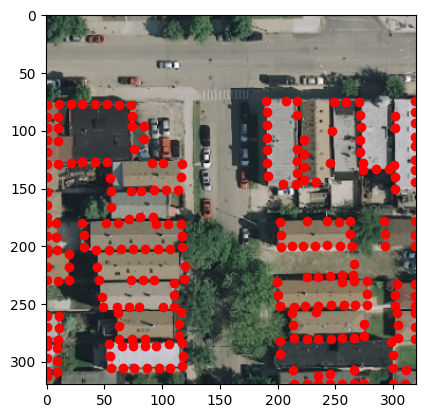

In [6]:
R2U = build_backbone(config2).to(device)
ckpt = torch.load(ckpt_path, map_location='cpu')
R2U.load_state_dict(ckpt['model_state_dict'])
# R2U.eval()
R2U.train()
ftm_R2U, htm_R2U, nms_R2U = R2U(images)
print(htm_R2U[1].unique())
image = images[1].detach().cpu().numpy().transpose(1,2,0)
nodes = nms_R2U[1][1].detach().cpu().numpy()

# Visualize
plt.imshow(min_max_normalize(image, 0))
plt.scatter(nodes[:,1], nodes[:,0], color='r')

plt.show()

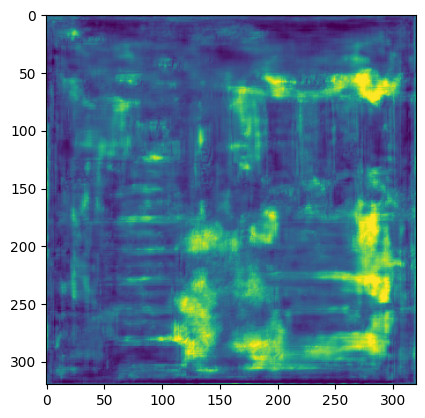

In [7]:
tmp1 = ftm_TopDiG[1][-1]
plt.imshow(min_max_normalize(tmp1.unsqueeze(2).detach().cpu().numpy(), 0.5))

tensor([[[[0.6296, 0.6441, 0.6209,  ..., 0.1434, 0.1325, 0.1177],
          [0.6716, 0.6141, 0.5368,  ..., 0.1466, 0.1499, 0.1050],
          [0.6685, 0.6670, 0.6158,  ..., 0.1396, 0.1605, 0.1327],
          ...,
          [0.4613, 0.4552, 0.4351,  ..., 0.5108, 0.5012, 0.4999],
          [0.4560, 0.4364, 0.4679,  ..., 0.5042, 0.4995, 0.5059],
          [0.4735, 0.4629, 0.4693,  ..., 0.4994, 0.5025, 0.4729]],

         [[0.6329, 0.6379, 0.6295,  ..., 0.1854, 0.1695, 0.1637],
          [0.6688, 0.6228, 0.5423,  ..., 0.1918, 0.2036, 0.1317],
          [0.6711, 0.6689, 0.6194,  ..., 0.1857, 0.2203, 0.1703],
          ...,
          [0.5240, 0.5160, 0.4952,  ..., 0.4448, 0.4333, 0.4402],
          [0.5186, 0.5052, 0.5335,  ..., 0.4457, 0.4407, 0.4440],
          [0.5325, 0.5221, 0.5188,  ..., 0.4444, 0.4474, 0.4177]],

         [[0.5589, 0.5666, 0.5554,  ..., 0.2167, 0.1999, 0.1876],
          [0.6043, 0.5400, 0.4632,  ..., 0.2221, 0.2281, 0.1587],
          [0.6015, 0.5932, 0.5413,  ..., 0

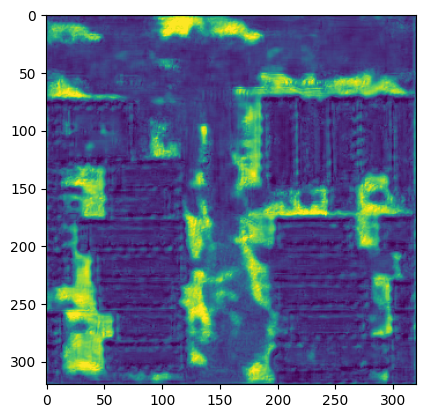

In [8]:
model.train()
ftm_TopDiG, htm_TopDiG, nms_TopDiG = model.backbone(images)
tmp1 = ftm_TopDiG[1][-1]
plt.imshow(min_max_normalize(tmp1.unsqueeze(2).detach().cpu().numpy(), 0.5))

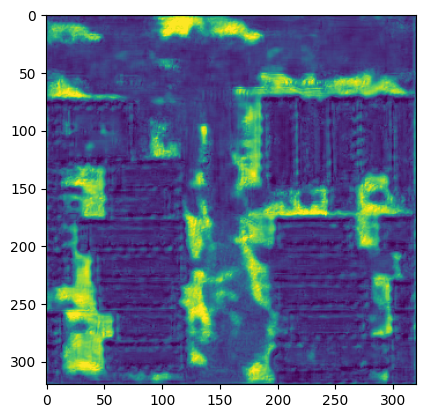

In [9]:
tmp2 = ftm_R2U[1][-1]
plt.imshow(min_max_normalize(tmp2.unsqueeze(2).detach().cpu().numpy(), 0.5))

In [10]:
# htm_R2U[1].softmax(1).unique()
# htm = htm_TopDiG[1].softmax(1).detach().numpy()
# htm = (htm * 255).astype('uint8')
# htm = np.squeeze(htm, axis=0)
# htm = Image.fromarray(htm, 'L')
# htm.save('/nas/tsgil/gil/infer_TopDiG/test.png')
# htm = r2u_htm[1].softmax(1).detach().numpy()
# htm = (htm * 255).astype('uint8')
# htm = np.squeeze(htm, axis=0)
# htm = Image.fromarray(htm, 'L')
# htm.save('/nas/tsgil/gil/infer_TopDiG/test2.png')
# nms_TopDiG[1].shape
# nodes.shape
# image = images[1].detach().cpu().numpy().transpose(1,2,0)
# nodes = nms_TopDiG[1][1].detach().cpu().numpy()

# # Visualize
# plt.imshow(min_max_normalize(image, 0))
# # plt.scatter(nodes[:,1], nodes[:,0], color='r')
# plt.scatter(nodes[:,1], nodes[:,0], color='r')

# plt.show()